In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [175]:
class WindowDataset(Dataset):
    # 단변량 시계열에서 입력값, 정답값을 만드는 Dataset
    def __init__(self, _data, _window):
        # _data : (N, ) 형태의 1차원 tensor 데이터
        # _window : 구간설정 (몇 개의 과거 데이터를 볼 것인가?)
        self.data = _data
        self.window = _window
        # 유효 샘플의 개수(학습 데이터의 개수)는 data의 전체 길이에서 -1
        # 입력 데이터는 전체 길이-윈도우
        self.n = len(_data) - _window
    
    # 아래의 특수 함수 __len__(), __getitem() 는 DataLoder에서 자동으로 호출해 사용되는 부분
    def __len__(self):
        return max(self.n, 0)

    def __getitem__(self, idx):
        # 변환
        # x는 입력 데이터(윈도우의 구간) ---> 문제
        # y는 입력 데이터 다음 행의 데이터 --> 정답
        x = self.data[idx : idx + self.window].unsqueeze(-1)  # (window, ) -> (window, 1) # 차원을 입힌 것
        y = self.data[idx + self.window].unsqueeze(-1)
        return x, y

In [176]:
# RNN class 정의
class RNNReg(nn.Module):
    # 해당 class에서 정의되는 함수는 생성자함수, forward() 함수

    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers= 1,
            nonlinearity= 'tanh',
            dropout= 0.0,
            bidirectional= False,
            batch_first= True
        ):
        # 부모 클래스의 생성자 함수 호출
        super().__init__()
        self.rnn = nn.RNN(
            input_size= input_size,
            hidden_size= hidden_size,
            num_layers= num_layers,
            nonlinearity= nonlinearity,
            dropout= dropout,
            bidirectional= bidirectional,
            batch_first= batch_first
        )
        # self.head = nn.linear(hidden_size, 1) # 1차원 스칼라 회귀
        # bidirectional의 값이 False인 경우에는 hidden_size를 사용
        # 만약 True라면 hidden_size * 2 (양방향이므로)
        out_features = hidden_size * ( 2 if bidirectional else 1 )
        # 선형 학습 모델 -> 비선형 학습 모델
        # self.head = nn.Linear(out_features, 1)    # 선형
        self.head = nn.Sequential(
            nn.Linear(out_features, out_features*2),
            nn.ReLU(),
            nn.Linear(out_features*2, 1)
        )
    def forward(self, x):
        # out -> 모든 시점에서의 은닉층의 값(결과)
        # h_n -> 마지막 시점에서의 은닉층의 값(결과) -> 시계열 분석은 마지막 시점(층이 존재하면 층별 마지막값)을 사용
        out, h_n = self.rnn(x)
        # 층이 여러 개일 수도 있으니, 가장 마지막 은닉층의 값을 사용 (마지막 층의 값)
        last_hidden = h_n[-1]
        res = self.head(last_hidden)
        return res

## 연습
- csv 폴더 안의 AAPL.csv 파일 로드
- Date, Adj Close 컬럼을 제외한 나머지는 모두 삭제
- 결측치가 포함되어 있는지 확인하고, 결측치 데이터가 전체 데이터 수에 비해 매우 적다면 제거
- 해당 데이터셋의 순서가 시간의 순서와 같은지 확인 (시간 컬럼을 기준으로 오름차순 정렬)
- tensor 데이터를 생성하기 위해 Adj Close의 데이터를 array 형태( (N, 1) )로 변경
- 75:25 비율로 train, test 데이터 분리
- 스케일러를 이용하여 train, test 데이터 스케일링
- train, test 데이터를 Tensor 형태로 변환
- Tensor 형태로 변환된 데이터를 WindowDataset의 형태로 변환하고, DataLoader를 이용하여 학습에 사용하기 편한 형태로 변경 (window의 개수는 60)

In [177]:
# csv 폴더 안의 AAPL.csv 파일 로드
df = pd.read_csv("../csv/AAPL.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9715 entries, 0 to 9714
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9715 non-null   object 
 1   Open       9714 non-null   float64
 2   High       9714 non-null   float64
 3   Low        9714 non-null   float64
 4   Close      9714 non-null   float64
 5   Adj Close  9714 non-null   float64
 6   Volume     9713 non-null   float64
dtypes: float64(6), object(1)
memory usage: 531.4+ KB


In [178]:
# Date, Adj Close 컬럼을 제외한 나머지는 모두 삭제
# 방법 1 - 나머지 모두 삭제
df2 = df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis= 1)
df2

,Date,Adj Close
0,1980-12-12,0.410525
1,1980-12-15,0.389106
2,1980-12-16,0.360548
3,1980-12-17,0.369472
4,1980-12-18,0.380182
...,...,...
9710,2019-06-18,198.449997
9711,2019-06-19,197.869995
9712,2019-06-20,199.460007
9713,2019-06-21,198.779999


In [179]:
# 방법 2 - Date, Adj Close 컬럼만 추출
# 삭제할 컬럼이 많으므로, 이 경우 방법 2가 더 편리
df = df[['Date', 'Adj Close']]
df

,Date,Adj Close
0,1980-12-12,0.410525
1,1980-12-15,0.389106
2,1980-12-16,0.360548
3,1980-12-17,0.369472
4,1980-12-18,0.380182
...,...,...
9710,2019-06-18,198.449997
9711,2019-06-19,197.869995
9712,2019-06-20,199.460007
9713,2019-06-21,198.779999


In [180]:
# 결측치가 포함되어 있는지, 결측치 데이터가 전체 데이터 수에 비해 적은지 확인
# sum, any, ...
na_cnt = df.isna().any(axis=1).sum()  # 결측치가 포함되어 있는 행의 개수

# 결측치 개수 / 전체 개수 * 100
round( na_cnt / len(df) * 100 , 2 )
# 0.01%

np.float64(0.01)

In [181]:
# 결측치의 개수가 전체에 비해 매우 적으므로 제거
# 방법 1 - loc
# 결측치가 포함되어 있는 행을 제외하고 필터링
df.loc[~df.isna().any(axis=1), ]

,Date,Adj Close
0,1980-12-12,0.410525
1,1980-12-15,0.389106
2,1980-12-16,0.360548
3,1980-12-17,0.369472
4,1980-12-18,0.380182
...,...,...
9710,2019-06-18,198.449997
9711,2019-06-19,197.869995
9712,2019-06-20,199.460007
9713,2019-06-21,198.779999


In [182]:
# 방법 2 - dropna()
# 결측치가 포함되어 있는 행을 삭제
df.dropna(axis= 0, inplace= True)
df.isna().sum()

Date         0
Adj Close    0
dtype: int64

In [183]:
# 해당 데이터셋의 순서가 시간의 순서와 같은지 확인 (시간 컬럼을 기준으로 오름차순 정렬)
df.sort_values('Date', inplace= True)

In [184]:
# tensor 데이터를 생성하기 위해 Adj Close의 데이터를 array 형태( (N, 1) )로 변경
values = df[['Adj Close']].values
# 출력:
    # array([  0.410525,   0.389106,   0.360548, ..., 199.460007, 198.779999,
    #       199.169998], shape=(9714,))

In [185]:
# 2차원의 데이터프레임에서 데이터를 뽑으면 2차원으로 나온다.
# 컬럼(단일 데이터)을 하나 선택(필터링)하면 필터의 조건이 '단일 데이터'이므로 차원이 축소된다.
# 따라서 데이터의 타입이 단일 데이터면 리스트나 튜플로 감싸줘야 한다.
# -> reshape를 통해 크기 재지정 없이 array로 변환 가능
# df['Adj Close'].values.reshape(-1, 1)

In [186]:
# 75:25 비율로 train, test 데이터 분리
split_idx = int( len(values) * 0.75 )

train_data = values[ :split_idx]
test_data = values[split_idx: ]
print(train_data.shape, test_data.shape)
# 스케일러를 이용하여 train, test 데이터 스케일링
# train, test 데이터를 Tensor 형태로 변환
# Tensor 형태로 변환된 데이터를 WindowDataset의 형태로 변환하고, DataLoader를 이용하여 학습에 사용하기 편한 형태로 변경

(7285, 1) (2429, 1)


In [187]:
# StandardScaler 를 이용하여 스케일링
# scaler = StandardScaler()
# MinMaxScaler 를 이용하여 스케일링 - 이 예제에선 훨씬 효과 좋음!
scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train_data)
test_sc = scaler.transform(test_data)

In [188]:
# 스케일링이 완료된 데이터셋을 Tensor로 변환
train_sc = torch.tensor(train_sc.squeeze(-1), dtype=torch.float32)
test_sc = torch.tensor(test_sc.squeeze(-1), dtype= torch.float32)

In [189]:
# Tensor 형태로 변환된 데이터를 WindowDataset의 형태로 변환하고,
# DataLoader를 이용하여 학습에 사용하기 편한 형태로 변경 (window의 개수는 60)
train_ds = WindowDataset(train_sc, 60)
test_ds = WindowDataset(test_sc, 60)

In [190]:
# train_dl = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=64)
train_dl = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=128)
# test_dl = DataLoader(test_ds, shuffle=False, drop_last=False, batch_size=128)
test_dl = DataLoader(test_ds, shuffle=False, drop_last=False, batch_size=256)

In [191]:
# 반복 학습 루프 생성
# 모델 생성
aapl_model = RNNReg( input_size= 1, hidden_size= 128)
# aapl_model = RNNReg( input_size= 1, hidden_size= 128, num_layers= 2, dropout=0.2 )
# 이렇게 하면 과적합

# 손실함수
criterion = nn.MSELoss()
# 옵티마이저
optimizer = optim.Adam(aapl_model.parameters(), lr = 0.0001)
# optimizer = optim.Adam(aapl_model.parameters(), lr = 0.001)
# optimizer = optim.Adam(aapl_model.parameters(), lr = 0.1)

성능 향상을 위해 수정해볼 수 있는 부분
- aapl_model의 매개변수 num_layers, dropout
- 옵티마이저의 lr
- 스케일러 변경 (Standard -> MinMax)
- 학습 모델 변경 (선형 -> 비선형)
- DataLoader의 pin_memory 매개변수의 값을 True로 변경 (CPU -> GPU)
    - 어차피 CPU에서 작업중이었기 때문에 큰 효과 X

In [192]:
# 평가 함수 생성
# 함수 호출 시 동시에 실행되는 데코레이터 생성
@torch.no_grad()                    # 이렇게 하거나
def evaluate_mse(dataloader):
    aapl_model.eval()
    total_loss, total_n = 0.0, 0
    # with torch.no_grad():         # 이렇게 하거나
    for x, y in dataloader:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        loss = criterion(yhat, y)
        total_loss += loss.item() * y.size(0)
        total_n += y.size(0)
    return total_loss / max(total_n, 1)

train_history, val_history = [], []
for epoch in range(20):
    aapl_model.train()
    running, n_seen = 0.0, 0
    for x, y in train_dl:
        x = x.float()
        y = y.float()
        optimizer.zero_grad()
        yhat = aapl_model(x)
        loss = criterion(yhat, y)
        loss.backward()
        # 기울기 폭주 방지 - nan값이 나올 수 있는 확률을 배제
        nn.utils.clip_grad_norm_(aapl_model.parameters(), 1.0)

        optimizer.step()

        running += loss.item() * y.size(0)
        n_seen += y.size(0)
    
    train_mse = running / max(n_seen, 1)
    val_mse = evaluate_mse(test_dl)
    train_history.append(train_mse)
    val_history.append(val_mse)
    print(f"epoch: {epoch+1}, train_mse: {train_mse :.4f}, val_mse: {val_mse :.4f}")

epoch: 1, train_mse: 0.0252, val_mse: 9.6262
epoch: 2, train_mse: 0.0009, val_mse: 7.7476
epoch: 3, train_mse: 0.0002, val_mse: 7.1719
epoch: 4, train_mse: 0.0002, val_mse: 6.8629
epoch: 5, train_mse: 0.0002, val_mse: 6.6805
epoch: 6, train_mse: 0.0001, val_mse: 6.4940
epoch: 7, train_mse: 0.0001, val_mse: 6.3964
epoch: 8, train_mse: 0.0001, val_mse: 6.2409
epoch: 9, train_mse: 0.0001, val_mse: 6.1266
epoch: 10, train_mse: 0.0001, val_mse: 6.0282
epoch: 11, train_mse: 0.0001, val_mse: 5.8947
epoch: 12, train_mse: 0.0001, val_mse: 5.7740
epoch: 13, train_mse: 0.0001, val_mse: 5.7614
epoch: 14, train_mse: 0.0001, val_mse: 5.6289
epoch: 15, train_mse: 0.0001, val_mse: 5.5749
epoch: 16, train_mse: 0.0001, val_mse: 5.4298
epoch: 17, train_mse: 0.0001, val_mse: 5.4237
epoch: 18, train_mse: 0.0001, val_mse: 5.2701
epoch: 19, train_mse: 0.0001, val_mse: 5.1996
epoch: 20, train_mse: 0.0001, val_mse: 5.1233


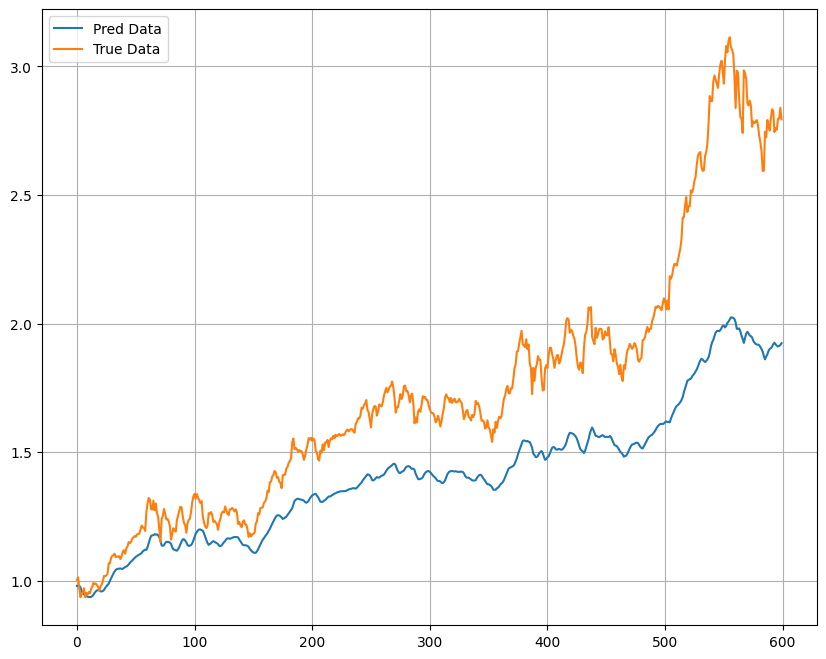

In [193]:
# 검증 셋 예측값과 실젯값을 그래프로 시각화
aapl_model.eval()

preds, trues = [], []

with torch.no_grad():
    for x, y in test_dl:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        preds.append(yhat.cpu())
        trues.append(y.cpu())

# preds, trues를 numpy 형태로 변환
preds = torch.cat(preds, dim=0).squeeze(-1).numpy()
trues = torch.cat(trues, dim=0).squeeze(-1).numpy()

plt.figure(figsize=(10, 8))
plt.plot(preds[:600], label= 'Pred Data')
plt.plot(trues[:600], label= 'True Data')
plt.legend()
plt.grid(True)
plt.show()

In [194]:
# 스케일링 데이터를 다시 원본의 데이터셋으로 변경
# inverse_transform(): 스케일링 데이터를 원본으로 변경
preds_origin = scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
trues_origin = scaler.inverse_transform(trues.reshape(-1, 1)).squeeze()

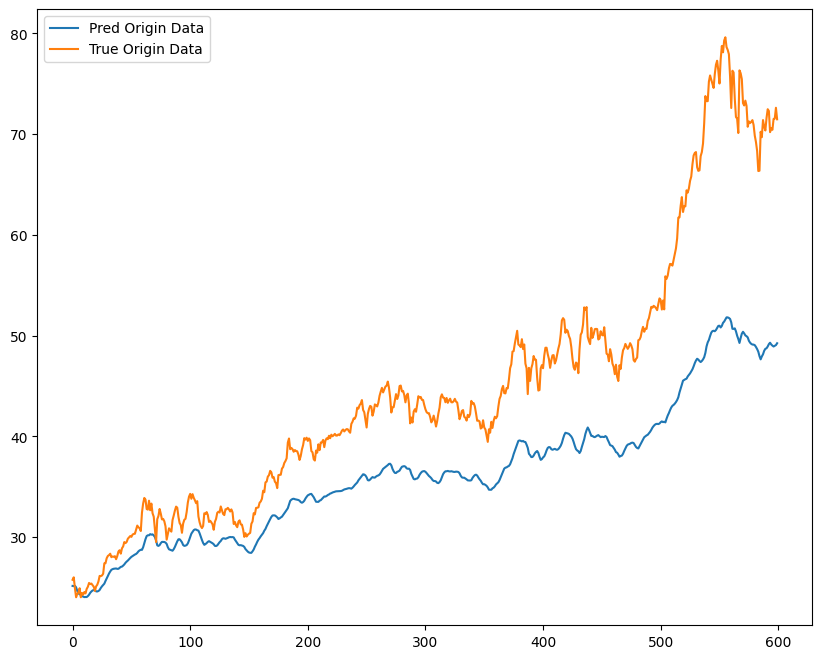

In [195]:
plt.figure(figsize=(10, 8))
plt.plot(preds_origin[:600], label= 'Pred Origin Data')
plt.plot(trues_origin[:600], label= 'True Origin Data')
plt.legend()
plt.show()